In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from ipywidgets import widgets, interact 
from IPython.display import display, clear_output
import plotly.plotly as py
import plotly.graph_objs as go
#from plotly.graph_objs import *
from plotly import tools

import pandas as pd
import numpy as np

%matplotlib inline
import random
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn.linearmodels import corrplot
from matplotlib.pyplot import *

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import sklearn.preprocessing as sk

In [2]:
df_price = pd.read_csv('../data/player_price.csv',',')
df_stats = pd.read_csv('../data/player_stats.csv',',')

df_price['timestamp'] = pd.to_datetime(df_price['timestamp'], unit='ms')
df_price['year'], df_price['month'], df_price['year_month'] = df_price['timestamp'].dt.year, df_price['timestamp'].dt.month, df_price['timestamp'].dt.year*100+df_price['timestamp'].dt.month 
#df_price.head()

In [3]:
%%time

df_stats['rare'] = df_stats.rareness.apply(lambda x: 1 if x=='rare' else 0)

df_stats['mental_aggression']=df_stats.aggression.apply(lambda x: 1 if x>65 else 0)
df_stats['mental_interceptions']=df_stats.interceptions.apply(lambda x: 1 if x>60 else 0)
df_stats['mental_vision']=df_stats.vision.apply(lambda x: 1 if x>67 else 0)
df_stats['mental_level']=df_stats['mental_aggression']+df_stats['mental_interceptions']+df_stats['mental_vision']
df_stats['mental_score']=df_stats['aggression']+df_stats['interceptions']+df_stats['vision']
df_stats['physical_score']=df_stats['acceleration']+df_stats['agility']+df_stats['jumping']+df_stats['speed']+df_stats['stamina']
df_stats['technical_score']=df_stats['crossing']+df_stats['curve']+df_stats['ball']+df_stats['dribbling']+df_stats['finishing']+df_stats['penalties']+df_stats['fk']+df_stats['long']+df_stats['volleys']+df_stats['short']+df_stats['sliding']
df_stats['total_score']=df_stats['mental_score']+df_stats['physical_score']+df_stats['technical_score']

d = {'gold' : 1, 'silver' : 2, 'bronze' : 3}
df_stats['colour'] = df_stats['colour'].map(d)

df_all = pd.merge( df_price, df_stats, how = "left", on = "player_id" )

df_all=df_all[df_all.xbox_price>0]

df_rare = df_all.groupby('timestamp').apply(lambda x: x[['rare']].count()).reset_index().rename(columns={'rare': 'rare_players'})
df_wfoot = df_all.groupby('timestamp').apply(lambda x: x[['weak_foot']].mean()).reset_index().rename(columns={'weak_foot': 'Avg_weak_foot'})
df_GK_avg_price= df_all[df_all.position=='GK'].groupby('timestamp').apply(lambda x: x[['xbox_price']].mean()).reset_index().rename(columns={'xbox_price': 'GK_avg_daily_price_change'})
df_avg_mental_score= df_all.groupby('timestamp').apply(lambda x: x[['mental_level']].mean()).reset_index().rename(columns={'mental_level': 'Avg_mental_score'})
df_avg_total_score= df_all.groupby('timestamp').apply(lambda x: x[['total_score']].mean()).reset_index().rename(columns={'total_score': 'Avg_total_score'})
df_timeboost = df_all.groupby('timestamp').apply(lambda x: x[['xbox_price']].mean()).reset_index().rename(columns={'xbox_price': 'All_avg_daily_price_change'})
df_bodies = df_all.groupby('timestamp').apply(lambda x: x[['player_id']].nunique()).reset_index().rename(columns={'player_id': 'nb_unique_players'})

df_nation_avg_price = df_all.groupby('nation').apply(lambda x: x[['xbox_price']].mean()).reset_index().rename(columns={'xbox_price': 'nation_avg_price'})
df_nation_max_price = df_all.groupby('nation').apply(lambda x: x[['xbox_price']].max()).reset_index().rename(columns={'xbox_price': 'nation_max_price'})

CPU times: user 7.01 s, sys: 996 ms, total: 8 s
Wall time: 8 s


In [4]:
#df_bodies
df_all=pd.merge(df_all,df_bodies,how='left', on='timestamp')

In [5]:
df_stats[['age','height','weight','rare','colour']].describe()

,age,height,weight,rare,colour
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,27.262769,181.866333,76.301674,0.640730,1.305151
std,4.992414,6.806372,7.100448,0.479839,0.522029
min,17.000000,163.000000,57.000000,0.000000,1.000000
25%,24.000000,177.000000,71.000000,0.000000,1.000000
50%,27.000000,182.000000,76.000000,1.000000,1.000000
75%,30.000000,187.000000,81.000000,1.000000,2.000000
max,76.000000,203.000000,102.000000,1.000000,3.000000


In [24]:
#df_all.columns.values

In [7]:
data_a = go.Scatter(x=df_timeboost['timestamp'], y=df_timeboost['All_avg_daily_price_change'], name='All_avg_daily_price_change')

data_b = go.Scatter(x=df_bodies['timestamp'],
            y=df_bodies['nb_unique_players'], name='Nb_of_unique_players')

data_c = go.Scatter(x=df_rare['timestamp'],
            y=df_rare['rare_players'], name='rare_players')

data_d = go.Scatter(x=df_GK_avg_price['timestamp'],
            y=df_GK_avg_price['GK_avg_daily_price_change'], name='GK_avg_daily_price_change')

data_e = go.Scatter(x=df_avg_mental_score['timestamp'],
            y=df_avg_mental_score['Avg_mental_score'], name='Avg_mental_score')

data_x = go.Scatter(x=df_avg_total_score['timestamp'],
            y=df_avg_total_score['Avg_total_score'], name='Avg_total_score')

data_i = go.Scatter(x=df_wfoot['timestamp'],
            y=df_wfoot ['Avg_weak_foot'], name='Avg_weak_foot')

#### Number of cards, prices and mental skills are growing over time.

In [8]:
data = [ data_e]  

         
fig = tools.make_subplots(rows=4, cols=2)

fig.append_trace(data_b, 1, 1)
fig.append_trace(data_e, 2, 1)

fig.append_trace(data_a, 1, 2)
fig.append_trace(data_d, 2, 2)

fig.append_trace(data_i, 3, 1)
fig.append_trace(data_x, 4, 1)

fig['layout'].update(height=600, width=1000, title='General trends over time')
py.iplot(fig, filename='diff')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]
[ (4,1) x7,y7 ]  [ (4,2) x8,y8 ]



### Correlations: age/skills/dates/rareness..

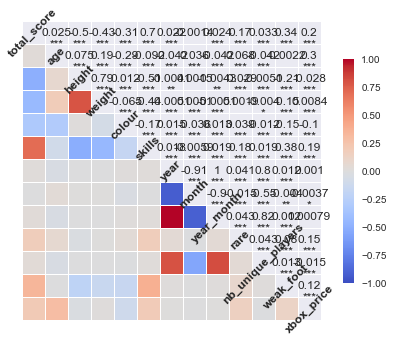

In [9]:
corrplot(df_all[['total_score','age','height', 'weight', 'colour', 'skills','year','month', 'year_month','rare','nb_unique_players','weak_foot','xbox_price']], annot=True, diag_names=True)

### Nation: scores, prices, players

In [10]:
df_stats_nation_mental_score=df_stats.groupby('nation').apply(lambda x: x[['mental_score']].mean()).reset_index().rename(columns={'mental_score': 'avg_mental_score'})
df_stats_nation_physical_score=df_stats.groupby('nation').apply(lambda x: x[['physical_score']].mean()).reset_index().rename(columns={'physical_score': 'avg_physical_score'})
df_stats_nation_technical_score=df_stats.groupby('nation').apply(lambda x: x[['technical_score']].mean()).reset_index().rename(columns={'technical_score': 'avg_technical_score'})
df_stats_nation_unique_players=df_stats.groupby('nation').apply(lambda x: x[['player_id']].nunique()).reset_index().rename(columns={'player_id': 'nb_of_unique_players'})
df_stats_nation_nb_of_GK=df_stats[df_stats.position=='GK'].groupby('nation').apply(lambda x: x[['player_id']].nunique()).fillna(0).reset_index().rename(columns={'player_id': 'nb_of_GK'}).fillna(0)
df_stats_nation_total_score=df_stats.groupby('nation').apply(lambda x: x[['total_score']].mean()).reset_index().rename(columns={'total_score': 'avg_total_score'})
df_stats_nation_age=df_stats.groupby('nation').apply(lambda x: x[['age']].mean()).reset_index().rename(columns={'age': 'avg_age'})

df_stats_nation=pd.merge(df_stats_nation_mental_score, df_stats_nation_unique_players, how='left', on='nation')
df_stats_nation=pd.merge(df_stats_nation, df_stats_nation_physical_score, how='left', on='nation')
df_stats_nation=pd.merge(df_stats_nation, df_stats_nation_technical_score, how='left', on='nation')
df_stats_nation=pd.merge(df_stats_nation, df_stats_nation_total_score, how='left', on='nation')
df_stats_nation=pd.merge(df_stats_nation, df_stats_nation_nb_of_GK, how='left', on='nation')
df_stats_nation=pd.merge(df_stats_nation, df_stats_nation_age, how='left', on='nation')

df_stats_nation=pd.merge(df_stats_nation, df_nation_avg_price, how='left', on='nation')
df_stats_nation=pd.merge(df_stats_nation, df_nation_max_price, how='left', on='nation')

df_stats_nation=df_stats_nation.fillna(0)

df_stats_nation.sort_values(['nb_of_unique_players'], ascending=[False], inplace=True)
df_stats_nation.head(10)

,nation,avg_mental_score,nb_of_unique_players,avg_physical_score,avg_technical_score,avg_total_score,nb_of_GK,avg_age,nation_avg_price,nation_max_price
89,Spain,186.959924,524,282.568702,677.127863,1146.656489,54.0,27.171756,16393.327339,1521657
37,France,191.563218,435,293.579310,690.140230,1175.282759,36.0,26.383908,42023.518060,3089000
41,Germany,183.739812,319,277.868339,644.583072,1106.191223,46.0,26.570533,31633.627086,2501000
13,Brazil,194.993528,309,295.912621,709.126214,1200.032362,23.0,27.579288,58551.464729,10000000
3,Argentina,184.067568,296,295.527027,693.743243,1173.337838,23.0,28.043919,52446.172821,8000000
52,Italy,179.197279,294,282.792517,643.061224,1105.051020,39.0,28.683673,26310.183889,2150444
32,England,180.103093,291,287.202749,649.189003,1116.494845,26.0,26.563574,25609.353860,1700000
78,Portugal,195.650307,163,302.319018,716.791411,1214.760736,13.0,26.822086,107044.404983,8323629
69,Netherlands,189.519737,152,295.269737,710.125000,1194.914474,11.0,27.802632,65227.284371,5275000
9,Belgium,193.259259,135,303.251852,755.370370,1251.881481,8.0,25.896296,75620.717172,3363629


In [11]:
df_stats_nation.describe()

,avg_mental_score,nb_of_unique_players,avg_physical_score,avg_technical_score,avg_total_score,nb_of_GK,avg_age,nation_avg_price,nation_max_price
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,1.020000e+02,1.020000e+02
mean,183.106504,45.107843,290.925117,669.003618,1143.035239,4.156863,27.327899,3.436845e+04,8.665760e+05
std,23.400796,91.919455,21.237742,90.783548,122.508096,9.526144,3.382194,1.282855e+05,1.751459e+06
min,90.000000,1.000000,226.000000,189.000000,505.000000,0.000000,20.000000,2.658294e+02,9.830000e+02
25%,171.313127,3.000000,276.796610,638.093750,1092.075000,0.000000,26.084890,2.074434e+03,1.000000e+04
50%,184.750000,12.000000,288.676136,683.136207,1156.935897,0.000000,27.185878,6.312532e+03,8.849350e+04
75%,196.503151,37.750000,302.984927,719.917553,1208.975000,3.000000,28.459790,2.632209e+04,9.250000e+05
max,234.000000,524.000000,355.000000,879.666667,1451.833333,54.000000,50.000000,1.267598e+06,1.000000e+07


In [12]:
df_stats_nation.sort_values(['nation_avg_price'], ascending=[False], inplace=True)


In [13]:
df_stats_nation[(df_stats_nation.nation=='Liberia') | (df_stats_nation.nation=='Gabon')].head()

,nation,avg_mental_score,nb_of_unique_players,avg_physical_score,avg_technical_score,avg_total_score,nb_of_GK,avg_age,nation_avg_price,nation_max_price
61,Liberia,213.0,1,355.0,832.0,1400.0,0.0,50.0,1.267598e+06,2139000
38,Gabon,193.5,10,325.4,812.8,1331.7,0.0,26.7,2.050319e+05,2024629


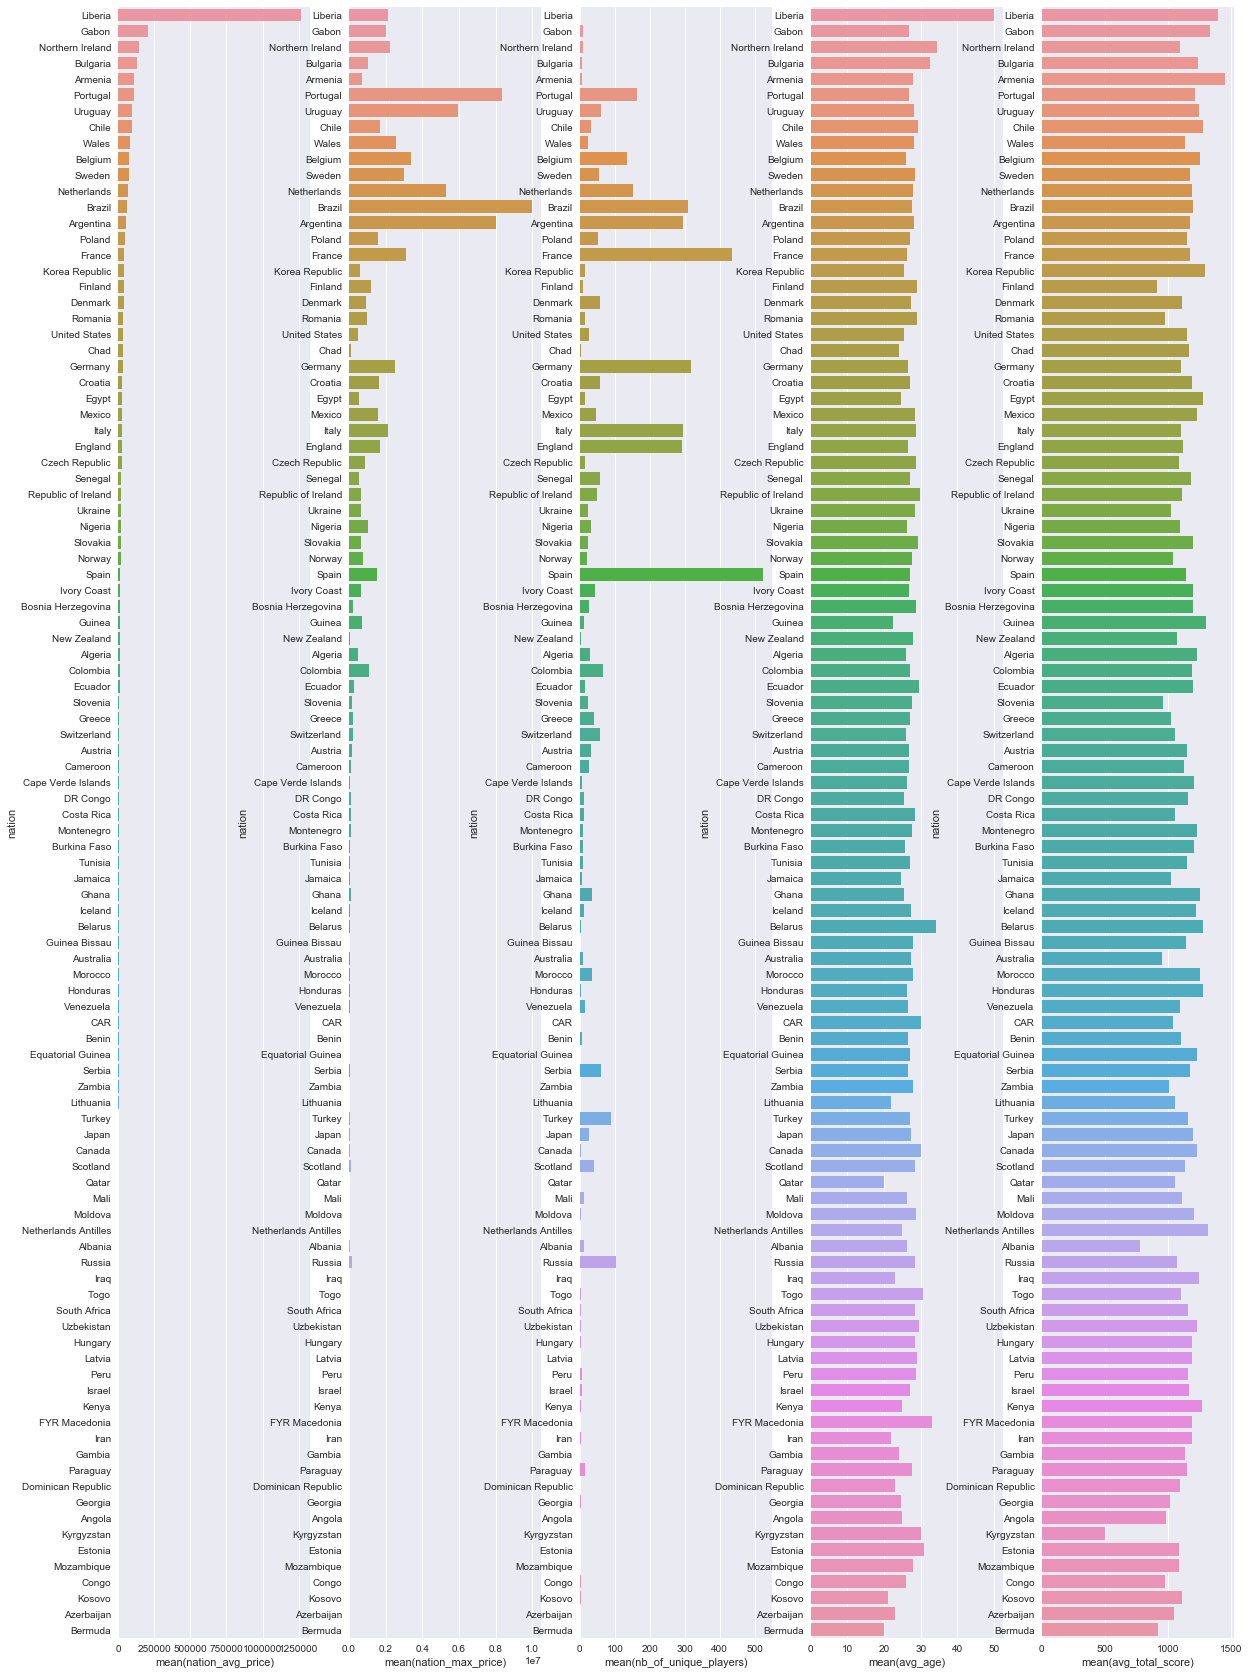

In [14]:
fig, axs = plt.subplots(ncols=5,figsize=(20,30))
sns.barplot(x="nation_avg_price", y="nation", data=df_stats_nation, ax=axs[0])
sns.barplot(x="nation_max_price", y="nation", data=df_stats_nation, ax=axs[1])
sns.barplot(x="nb_of_unique_players", y="nation", data=df_stats_nation, ax=axs[2])
sns.barplot(x="avg_age", y="nation", data=df_stats_nation, ax=axs[3])
sns.barplot(x="avg_total_score", y="nation", data=df_stats_nation, ax=axs[4])


In [15]:

data_a = go.Bar(x=df_stats_nation.nation,
                  y=df_stats_nation.avg_mental_score,
                  name='Avg mental score')

data_b = go.Bar(x=df_stats_nation.nation,
                  y=df_stats_nation.nb_of_unique_players,
                  name='Nb of unique players')

data_c = go.Bar(x=df_stats_nation.nation,
                  y=df_stats_nation.avg_physical_score,
                  name='Avg physical score')

data_d = go.Bar(x=df_stats_nation.nation,
                  y=df_stats_nation.avg_technical_score,
                  name='Avg technical score')

layout = go.Layout(title="Nations insides )) ",
                xaxis=dict(title='Nation'),
                yaxis=dict(title='Mental score '))


data = [data_a , data_b, data_c, data_d  ]
layout = go.Layout(title="Nations",
                xaxis=dict(title='Nations'),
                yaxis=dict(title='Scores'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='diff')


### PCA...

In [16]:
df_test=df_all[['total_score','age','height', 'weight', 'colour', 'skills','year','month', 'year_month','rare','nb_unique_players','weak_foot','xbox_price']]

In [17]:
df_test['price_quartile'] = pd.qcut(df_test['xbox_price'], 5, labels=False)
df_test=df_test.fillna(0)

In [18]:
df_target=df_test['price_quartile']
df_in=df_test[['total_score','age','height', 'weight', 'colour', 'skills','year','month', 'year_month','rare','nb_unique_players','weak_foot']]

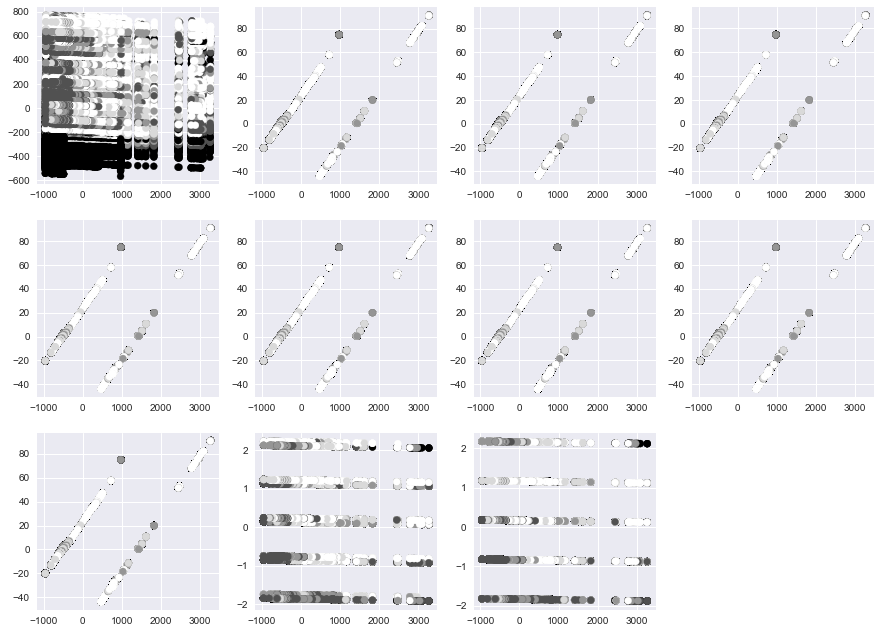

In [19]:
fig=figure(figsize=(15, 15))

for it in range(1,df_in.shape[1]):
    df_in_entry=df_in.iloc[:,it-1:]
    
    X_pca = PCA().fit_transform(df_in_entry.values)
    subplot(4,4,it)
    scatter(X_pca[:, 0], X_pca[:, 1], c=df_target)
    


In [22]:
df_target=df_test['price_quartile']

scaler = sk.StandardScaler() 
df_in=scaler.fit_transform(df_test[['total_score','age','height', 'weight', 'colour', 'skills','year','month', 'year_month','rare','nb_unique_players','weak_foot']])

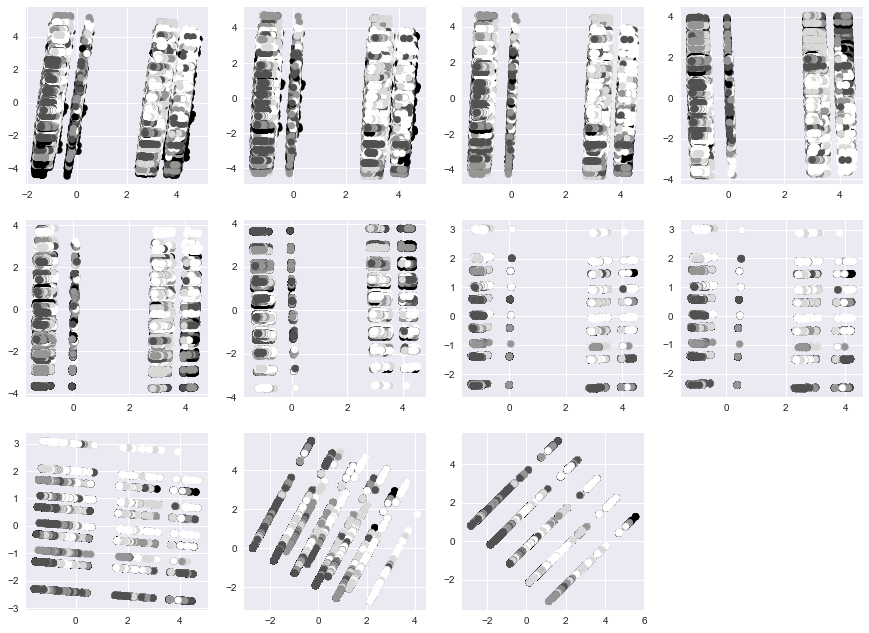

In [23]:
fig=figure(figsize=(15, 15))

for it in range(1,df_in.shape[1]):
    df_in_entry=df_in[:,it-1:]
    
    X_pca = PCA().fit_transform(df_in_entry)
    subplot(4,4,it)
    scatter(X_pca[:, 0], X_pca[:, 1], c=df_target)
    